In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.feature_selection import RFE

In [2]:
training_data = pd.read_csv('/kaggle/input/mekong-training-testing-set/merged_train.csv')
testing_data = pd.read_csv('/kaggle/input/mekong-training-testing-set/merged_test.csv')

In [3]:
# Change the type into date time
def into_datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

In [4]:
into_datetime(training_data)
into_datetime(testing_data)

In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   AWEInsh    223 non-null    float64       
 1   AWEIsh     223 non-null    float64       
 2   MNDWI      223 non-null    float64       
 3   NDWI       223 non-null    float64       
 4   SR_B1      223 non-null    float64       
 5   SR_B2      223 non-null    float64       
 6   SR_B3      223 non-null    float64       
 7   SR_B4      223 non-null    float64       
 8   SR_B5      223 non-null    float64       
 9   SR_B7      223 non-null    float64       
 10  WI1        223 non-null    float64       
 11  WI2        223 non-null    float64       
 12  date       223 non-null    datetime64[ns]
 13  pivot      223 non-null    int64         
 14  reducer    223 non-null    object        
 15  source     223 non-null    object        
 16  Station    223 non-null    object        
 1

In [6]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   AWEInsh    35 non-null     float64       
 1   AWEIsh     35 non-null     float64       
 2   MNDWI      35 non-null     float64       
 3   NDWI       35 non-null     float64       
 4   SR_B1      35 non-null     float64       
 5   SR_B2      35 non-null     float64       
 6   SR_B3      35 non-null     float64       
 7   SR_B4      35 non-null     float64       
 8   SR_B5      35 non-null     float64       
 9   SR_B7      35 non-null     float64       
 10  WI1        35 non-null     float64       
 11  WI2        35 non-null     float64       
 12  date       35 non-null     datetime64[ns]
 13  pivot      35 non-null     int64         
 14  reducer    35 non-null     object        
 15  source     35 non-null     object        
 16  Station    35 non-null     object        
 17 

In [7]:
training_data['month_sin'] = np.sin(2 * np.pi * training_data['month'] / 12)
training_data['month_cos'] = np.cos(2 * np.pi * training_data['month'] / 12)
testing_data['month_sin'] = np.sin(2 * np.pi * testing_data['month'] / 12)
testing_data['month_cos'] = np.cos(2 * np.pi * testing_data['month'] / 12)

In [8]:
features = [ 'SR_B5', 'SR_B7',  'Latitude', 'Longitude', 
            'AWEInsh', 'AWEIsh', 'MNDWI', 'NDWI', 'SR_B1', 
            'SR_B4', 'WI1', 'WI2', 'month_sin', 'month_cos', 'year' ]

In [9]:
target = 'max'

In [10]:
# Split data
X_train = training_data[features]
y_train = training_data[target]
X_test = testing_data[features]
y_test = testing_data[target]

In [11]:
print("Training Target Summary:")
print(y_train.describe())

print("\nTesting Target Summary:")
print(y_test.describe())

Training Target Summary:
count    223.000000
mean      10.682063
std        8.359002
min        0.100000
25%        3.900000
50%        9.200000
75%       17.050000
max       39.000000
Name: max, dtype: float64

Testing Target Summary:
count    35.000000
mean      7.334286
std       7.547222
min       0.100000
25%       1.000000
50%       5.400000
75%      11.600000
max      31.000000
Name: max, dtype: float64


In [12]:
# Define model
model = RandomForestRegressor(random_state=42)

In [13]:
# Apply RFE
rfe = RFE(estimator=model, n_features_to_select=10)  # Choose number of features
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

In [14]:
param_grid = {
    'n_estimators': [100, 150],             # Fewer trees to reduce variance
    'max_depth': [2,3],                 # Shallow trees generalize better
    'min_samples_split': [8, 10, 12],       # Require more samples to split
    'min_samples_leaf': [6,8,10],          # Larger leaf nodes
    'max_features': [0.4, 0.6, 0.8],        # Fewer features per split
    'bootstrap': [True]                     # Use randomness to avoid overfitting
}

In [15]:
# Initialize and run GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=2)

In [16]:
grid_search.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END bootstrap=True, max_depth=2, max_features=0.4, min_samples_leaf=6, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=0.4, min_samples_leaf=6, min_samples_split=8, n_estimators=150; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=0.4, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=0.4, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=0.4, min_samples_leaf=6, min_samples_split=10, n_estimators=150; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=0.4, min_samples_leaf=6, min_samples_split=12, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=0.4, min_samples_leaf=6, min_samples_split=12, n_estimators=150; total time=  

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 3],
                         'max_features': [0.4, 0.6, 0.8],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [17]:
# Best model
best_model = grid_search.best_estimator_

In [18]:
# Predict (inverse log1p → expm1)
y_pred = best_model.predict(X_test_rfe)

In [19]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
import numpy as np

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

def evaluate_model(model, X, y, dataset_name=""):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    medae = median_absolute_error(y, y_pred)
    wmape_score = wmape(y, y_pred)
    smape_score = smape(y, y_pred)

    print(f"\n📊 Evaluation on {dataset_name} Set:")
    print(f"• RMSE   : {rmse:.4f}")
    print(f"• R²     : {r2:.4f}")
    print(f"• MAE    : {mae:.4f}")
    print(f"• WMAPE  : {wmape_score:.2f}%")

In [20]:
# Print best parameters
print("✅ Best Parameters from GridSearchCV:")
print(grid_search.best_params_)

✅ Best Parameters from GridSearchCV:
{'bootstrap': True, 'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 150}


In [21]:
# Evaluate on both sets
evaluate_model(best_model, X_train_rfe, y_train, "Training")


📊 Evaluation on Training Set:
• RMSE   : 4.7706
• R²     : 0.6728
• MAE    : 3.6212
• WMAPE  : 33.90%


In [22]:
evaluate_model(best_model, X_test_rfe, y_test, "Testing")


📊 Evaluation on Testing Set:
• RMSE   : 4.5563
• R²     : 0.6248
• MAE    : 3.9903
• WMAPE  : 54.41%


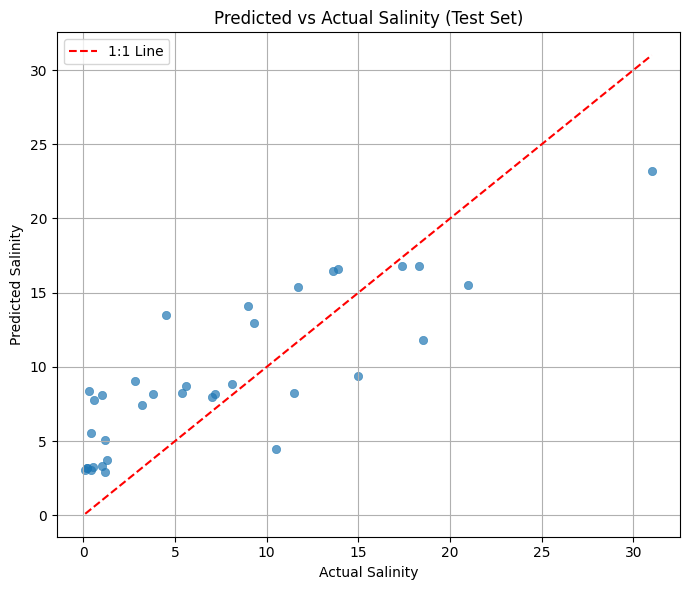

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, edgecolor=None)

# Add 1:1 reference line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='1:1 Line')

plt.xlabel('Actual Salinity')
plt.ylabel('Predicted Salinity')
plt.title('Predicted vs Actual Salinity (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

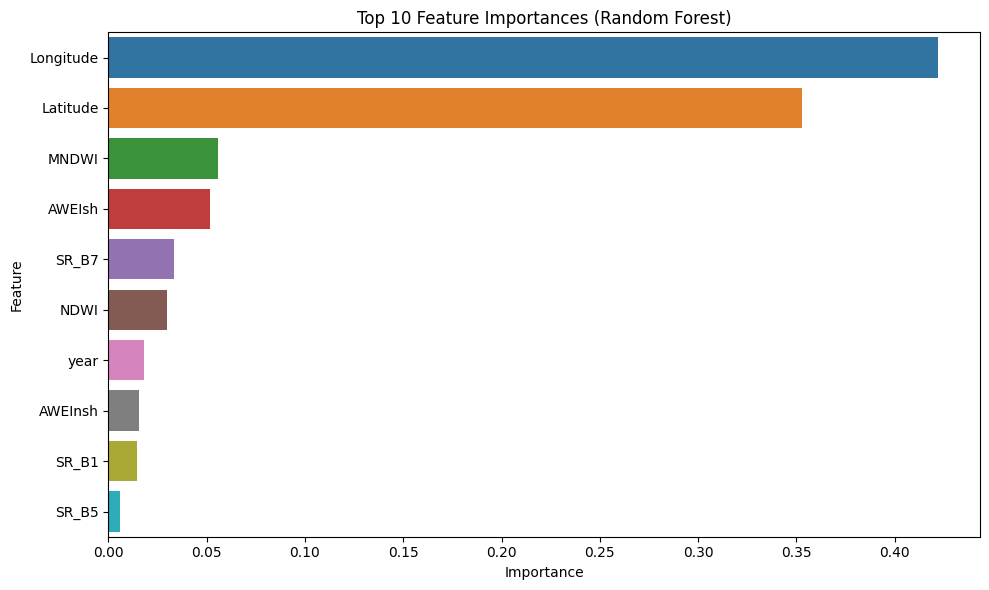

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get selected feature names from original DataFrame
selected_features = X_train.columns[rfe.support_]

# Create a DataFrame of features and their importances
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()